## Download dataset

### Import libraries

In [198]:
import os
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from keras.preprocessing.text import Tokenizer
from keras import backend as K
import tensorflow as tf

import keras
from keras.models import Model 
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import LSTM
from keras.layers import Add
from keras.layers import Average
from keras.layers import Reshape
from keras.layers import Flatten

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [199]:
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

# Uncomment if you need to dowload the dataset
#download_data('dataset')

# Preprocessing data


In [200]:
#create a dataframe for the training data 
train_df = pd.read_csv('./dataset/train_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
train_df

"""train_df = pd.read_csv('./dataset/train_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
train_df["Evidence"] = train_df["Evidence"].str.split(pat = "\t")
train_df["evidenceID"]=train_df["Evidence"].str[0]
train_df["Evidence"]=train_df["Evidence"].str[1]
train_df["Label"] = train_df["Label"].replace({'SUPPORTS': 1, 'REFUTES': 0})

train_df"""

#create a dataframe for the validation data 
val_df = pd.read_csv('./dataset/val_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
val_df

#create a dataframe for the test data 
test_df = pd.read_csv('./dataset/test_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
test_df

,Claim,Evidence,claimID,Label
0,Anxiety has been linked with physical symptoms.,"13\tFurthermore , anxiety has been linked with...",16387,SUPPORTS
1,Firefox is an application.,0\tMozilla Firefox -LRB- or simply Firefox -RR...,6,SUPPORTS
2,Keegan-Michael Key played President Barack Oba...,"6\tIn 2015 , Key appeared at the White House C...",16392,SUPPORTS
3,Google Search can find stock quotes.,"13\tThese include synonyms , weather forecasts...",16394,SUPPORTS
4,A Good Day to Die Hard was directed solely by ...,1\tThe film was directed by John Moore and wri...,98315,REFUTES
...,...,...,...,...
7184,Scandal is an American band.,0\tScandal is an American rock band from the 1...,16378,SUPPORTS
7185,Henry Cavill played Superman.,8\tCavill gained further prominence and intern...,143046,SUPPORTS
7186,The Africa Cup of Nations is a friendly global...,"0\tThe Africa Cup of Nations , officially CAN ...",16382,REFUTES
7187,Ron Dennis is the owner of a catering company ...,"0\tAbsolute Taste , is a London-based catering...",147455,SUPPORTS


In [201]:
y_train = np.array(train_df['Label'])
y_val = np.array(val_df['Label'])
y_test = np.array(test_df['Label'])

### Tokenize and pad data

In [202]:
# The tokenizer will have an index 1 for OOV words. A lot of words in test and val will be 1.
tokenizer = Tokenizer(oov_token=1)

tokenizer.fit_on_texts(train_df["Claim"])
tokenizer.fit_on_texts(train_df["Evidence"])

In [203]:
MAX_SEQ_LEN = np.max([len(text.split()) for text in train_df["Evidence"]])

In [204]:
def textToTensor(tokenizer, max_len, text):
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences=seq, maxlen=max_len)
    return padded

In [205]:
claim_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["Claim"])
evidence_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["Evidence"])

claim_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["Claim"])
evidence_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["Evidence"])

claim_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["Claim"])
evidence_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["Evidence"])

In [206]:
claim_train.shape

(121740, 237)

In [207]:
VOCABULARY_LENGTH = len(tokenizer.word_index) + 1
VOCABULARY_LENGTH

35800

In [208]:
y_train = np.array([1 if x=='SUPPORTS' else 0 for x in train_df["Label"]])
y_val = np.array([1 if x=='SUPPORTS' else 0 for x in val_df["Label"]])
y_test = np.array([1 if x=='SUPPORTS' else 0 for x in test_df["Label"]])

In [209]:
type(y_train)

numpy.ndarray

## Create model

In [210]:
def create_model(max_tokens, vocab_length, embedding_dimension, sentence_embedding_type=1):    
    claims_input = Input(shape=(max_tokens, ))
    evidence_input = Input(shape=(max_tokens, ))
    
    claims_embedding = Embedding(vocab_length, embedding_dimension, name='WordEmbedding_claims')(claims_input)
    evidence_embedding = Embedding(vocab_length, embedding_dimension, name='WordEmbedding_evidence')(evidence_input)
    if sentence_embedding_type==1:
        # Encode token sequences via a RNN and take the last state as the sentence embedding.
        claims_sentence_embedding = LSTM(embedding_dimension, return_sequences=False, name='SentenceEmbedding_claims')(claims_embedding)
        evidence_sentence_embedding = LSTM(embedding_dimension, return_sequences=False, name='SentenceEmbedding_evidence')(evidence_embedding)
    elif sentence_embedding_type==2:
        # Encode token sequences via a RNN and average all the output states.

        # Put return_sequences True to get output from all hidden states
        claims_sentence_embedding = LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_claims')(claims_embedding)
        evidence_sentence_embedding = LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_evidence')(evidence_embedding)
        
        # Take average of outputs
        claims_sentence_embedding = K.mean(claims_sentence_embedding, axis=1)
        evidence_sentence_embedding = K.mean(evidence_sentence_embedding, axis=1)

    elif sentence_embedding_type==3:
        # Encode token sequences via a simple MLP layer.
        num = embedding_dimension*max_tokens
        # Reshape 3d vector to 2d
        claims_sentence_embedding = Reshape((num,), input_shape=(max_tokens, embedding_dimension))(claims_embedding)
        evidence_sentence_embedding = Reshape((num,), input_shape=(max_tokens, embedding_dimension))(evidence_embedding)

        # Send into dense layer
        claims_sentence_embedding = Dense(num, name='SentenceEmbedding_claims')(claims_sentence_embedding)
        evidence_sentence_embedding = Dense(num, name='SentenceEmbedding_evidence')(evidence_sentence_embedding)
   
    elif sentence_embedding_type==4:
        # Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
        claims_sentence_embedding = K.mean(claims_embedding, axis=1)
        evidence_sentence_embedding = K.mean(evidence_embedding, axis=1)
    else:
        raise Exception("Sentence embedding type must be an integer between 1 and 4")
    #Concatenation
    merged = Concatenate(axis=1)([claims_sentence_embedding, evidence_sentence_embedding])
    
    #Sum
    #merged = Add([claims_sentence_embedding, evidence_sentence_embedding])
    
    #Mean
    #merged = Average(axis=1)([claims_sentence_embedding, evidence_sentence_embedding])

    out = (Dense(1, activation='sigmoid'))(merged)

    model = Model(inputs=[claims_input, evidence_input], outputs=[out])
    
    return model

In [211]:
model = create_model(MAX_SEQ_LEN, VOCABULARY_LENGTH, 50)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 237)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 237)]        0           []                               
                                                                                                  
 WordEmbedding_claims (Embeddin  (None, 237, 50)     1790000     ['input_7[0][0]']                
 g)                                                                                               
                                                                                                  
 WordEmbedding_evidence (Embedd  (None, 237, 50)     1790000     ['input_8[0][0]']          

## Train model

In [212]:
model.compile(loss='mse',
              optimizer='Adam',
              metrics=['acc'])
history = model.fit(x=[claim_train, evidence_train], y=y_train, batch_size=100, epochs=10, validation_data=([claim_val, evidence_val], y_val))

Epoch 1/10
1218/1218 [==============================] - 359s 291ms/step - loss: 0.1305 - acc: 0.8263 - val_loss: 0.1873 - val_acc: 0.7181
Epoch 2/10
1218/1218 [==============================] - 356s 292ms/step - loss: 0.1001 - acc: 0.8664 - val_loss: 0.1871 - val_acc: 0.7390
Epoch 3/10
1218/1218 [==============================] - 496s 408ms/step - loss: 0.0862 - acc: 0.8861 - val_loss: 0.1875 - val_acc: 0.7393
Epoch 4/10
1218/1218 [==============================] - 489s 401ms/step - loss: 0.0763 - acc: 0.9010 - val_loss: 0.1919 - val_acc: 0.7410
Epoch 5/10
1218/1218 [==============================] - 372s 305ms/step - loss: 0.0681 - acc: 0.9123 - val_loss: 0.2009 - val_acc: 0.7359
Epoch 6/10
1218/1218 [==============================] - 400s 328ms/step - loss: 0.0618 - acc: 0.9205 - val_loss: 0.2023 - val_acc: 0.7347
Epoch 7/10
1218/1218 [==============================] - 428s 352ms/step - loss: 0.0557 - acc: 0.9296 - val_loss: 0.2077 - val_acc: 0.7324
Epoch 8/10
1218/1218 [============

In [213]:
model.save('models/test_model') #Save model

INFO:tensorflow:Assets written to: models/test_model/assets


INFO:tensorflow:Assets written to: models/test_model/assets


## Prediction

In [223]:
def prediction(model: keras.Model, x, predicting_info):
    predictions = model.predict(x, **predicting_info)
    return predictions

In [224]:
predictions = prediction(model, [claim_test, evidence_test], {'batch_size': 100})
predictions = np.rint(predictions)

## Evaluation

### Multi-input classification evaluation

#### Defining plotting functions

In [225]:
def plot_accuracy(model_callback):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_confusion_matrix(confusion_matrix):

    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

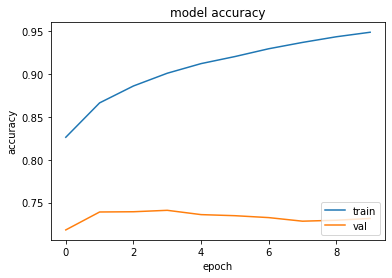

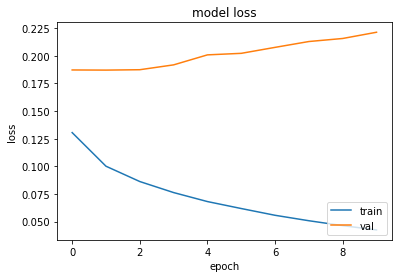

In [226]:
plot_accuracy(history)
plot_loss(history)

In [227]:
def evaluation(predictions):
    print(classification_report(y_test, predictions))
    print(accuracy_score(y_test, predictions))
    cf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cf_matrix)

              precision    recall  f1-score   support

           0       0.77      0.62      0.68      3583
           1       0.68      0.81      0.74      3606

    accuracy                           0.72      7189
   macro avg       0.72      0.71      0.71      7189
weighted avg       0.72      0.72      0.71      7189

0.7152594241201836


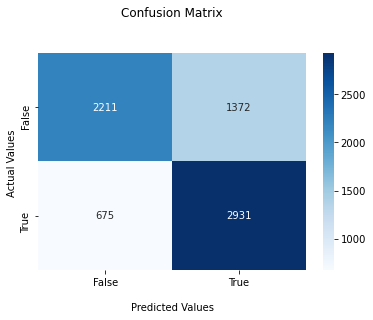

In [228]:
evaluation(predictions)

### Claim verification evaluation

In [229]:
def make_claims_dict():
    """Makes a dictionary with claimID as key and a list of the index for every evidence corresponding to the claim as value"""
    claims = {}
    t = test_df.groupby("claimID")
    for name, group in t:
        claims[name] = list(group.index)

In [230]:
claims_dict = make_claims_dict()

In [231]:
def majority_pred(predictions):
    """Find predictions based on majority voting"""
    majority = []

    for i in range(len(claim_test)):
        claim_id = np.array(test_df['claimID'])[i]
        support = 0
        defutes = 0
        for evidence in claims[claim_id]:
            if predictions[evidence] == 1:
                support += 1
            else:
                defutes += 1
        if support > defutes:
            majority.append(1.0)
        else:
            majority.append(0.0)

In [232]:
majority_predictions = majority_pred(predictions)

In [233]:
evaluation(majority_predictions)

ValueError: Expected array-like (array or non-string sequence), got None